In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import datetime as dt
import os
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from dtw import dtw
from sklearn.metrics import pairwise_distances
import pickle
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

C:\Users\JingYou\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
PRE_NAME = "onemin_ohlc_"
BEGIN_TIME = "09:00:00"
END_TIME = "10:30:00"
NUM_CLUSTER = 50
TIME_STEP = 5

In [240]:
def load_data(date_begin='20180612', date_end = '20200301', split_date_begin = '20200302', split_date_end = '20200915', train = True):
# def load_data(date_begin='20180612', date_end = '20180730', split_date_begin = '20180801', split_date_end = '20180830', train = True):

    X = []
    Y = []
    h1, m1, s1 = [int(x) for x in BEGIN_TIME.split(":")]
    h2, m2, s2 = [int(x) for x in END_TIME.split(":")]
    t1 = dt.timedelta(hours = h1, minutes=m1)
    t2 = dt.timedelta(hours = h2, minutes=m2)
    total_mins = (t2-t1).total_seconds()//60
    
    
    for sid in tqdm(os.listdir(os.path.join('dataset'))):
        for file in os.listdir(os.path.join('dataset', sid)):
            curday = file[12:20]
            if (train == True and curday <= date_end and curday >= date_begin) or (train == False and curday >= split_date_begin and curday <= split_date_end):
                df = pd.read_csv(os.path.join('dataset', sid, file))
                df = df
                mask = (df.loc[:, "time"] >= BEGIN_TIME) & (df.loc[:, "time"] <= END_TIME)
                front_df = df[mask].loc[:, "return"]
                front_df = front_df.take(np.arange(0, len(front_df), TIME_STEP))
                end_df = df[~mask].loc[:, "close"]
                if len(front_df) == (total_mins // TIME_STEP +1):
                    X.append(np.array(front_df))
                    Y.append(np.array(end_df))
    return np.array(X), np.array(Y)

# def dtw_d(X, Y):
#     manhattan_distance = lambda x, y: np.abs(x - y)
#     d, cost_matrix, acc_cost_matrix, path = dtw(X, Y, dist=manhattan_distance)
#     return d

# def dtw_affinity(X):
#     return pairwise_distances(X, metric=dtw_d)

# def fastdtw_d(X, Y):
#     return fastdtw(X, Y, dist=euclidean)[0]

# def fastdtw_affinity(X):
#     return pairwise_distances(X, metric=fastdtw_d)

def show_clustering():
    for n in range(NUM_CLUSTER):
        plt.title(n)
        for i in range(len(X)):
        #     plt.subplot(10, 1, X_label[i]+1)
            if X_label[i] == n:
                plt.plot(X[i])
        plt.show()
def train(max_iter = 300, n_clusters = 50):
    t1 = time.time()
    km = TimeSeriesKMeans(max_iter = max_iter, n_clusters=n_clusters, metric="dtw", n_jobs=5)
    X_label = km.fit_predict(X)
    t2 = time.time()
    print("training time", t2-t1)
    return km

def make_long_simple(y, cost):
    return y.max(),   y[0] * (1 + cost)
def make_short_simple(y, cost):
    return y[0], y.min() * (1 + cost)
def make_long_max_lost(y, cost):
    return y.min() - y[0] - cost
def make_short_max_lost(y, cost):
    return y[0], - y.max() - cost

def make_long(y, cost, exp_profit):
    if (y- (y[0] * (1+cost)) >= exp_profit).any():
        return y[0] *( 1 + exp_profit),   y[0] * (1 + cost)
    else:
        return y[-1],   y[0] * (1 + cost)
    
def make_short(y, cost, exp_profit):
    if (y[0] - y >=  y[0] * (exp_profit + cost)).any():
        return y[0] * (1-cost), y[0] * (1-exp_profit) 
    else:
        return y[0] * (1-cost), y[-1]
    
def evaluate_km(X_test, Y_test, X_label, exp_profit=0.025):
    profit_long_array = np.zeros(NUM_CLUSTER)
    profit_short_array = np.zeros(NUM_CLUSTER)
    cost_long_array = np.zeros(NUM_CLUSTER)
    cost_short_array = np.zeros(NUM_CLUSTER)
    num_exchange_array = np.zeros(NUM_CLUSTER).astype("int")
    for i in range(len(X_test)):
    #     p, l = make_long_simple(Y[i], 0.002)
    #     profit_long_array[X_label[i]] += p
    #     cost_short_array[X_label[i]] += l
        p, l = make_short(Y_test[i], 0.002, exp_profit)
        profit_short_array[X_label[i]] += p
        cost_short_array[X_label[i]] += l
        num_exchange_array[X_label[i]] += 1

    return profit_long_array, profit_short_array, cost_long_array, cost_short_array, num_exchange_array

y = Y[2]

exp_profit = 0.025
cost = 0.002

y[0] - y

y[0] * (exp_profit+cost)

y = Y[1]

y[0]*(1-0.025)

make_short(Y[0], 0.02, 0.04)

In [129]:
X, Y = load_data()

100%|██████████| 13/13 [00:49<00:00,  3.78s/it]


In [130]:
X_test, Y_test = load_data(train=False)

100%|██████████| 13/13 [00:22<00:00,  1.76s/it]


In [7]:
print(X.shape)

(2990, 19)


In [8]:
print(X_test.shape)

(915, 19)


t1 = time.time()
fastdtw_affinity(X)
t2 = time.time()
print("time:", t2-t1)
t1 = time.time()
dtw_affinity(X)
t2 = time.time()
print("time:", t2-t1)

In [107]:
km = train()

training time 175.69941186904907


t1 = time.time()
ac = AgglomerativeClustering(n_clusters = NUM_CLUSTER,
                             affinity = fastdtw_affinity,
                             linkage = 'complete')
X_label = ac.fit_predict(X)
t2 = time.time()
print(t2-t1)

t1 = time.time()
km = TimeSeriesKMeans(n_clusters=50, metric="dtw", n_jobs=5)
X_label = km.fit_predict(X)
t2 = time.time()
print("time", t2-t1)

t1 = time.time()
ac = AgglomerativeClustering(n_clusters = NUM_CLUSTER,
                             affinity = dtw_affinity,
                             linkage = 'complete')
X_label = ac.fit_predict(X)
t2 = time.time()
print(t2-t1)

t1 = time.time()
ac = AgglomerativeClustering(n_clusters = NUM_CLUSTER,
                             linkage = 'complete')
X_label = ac.fit_predict(X)
t2 = time.time()
print(t2-t1)

In [149]:
X_label

array([20, 25, 20, ...,  3, 17, 11], dtype=int64)

pickle.dump(X, open(os.path.join('dataset_pk',"X_ts.pk"), "wb"))
pickle.dump(Y, open(os.path.join('dataset_pk',"Y_ts.pk"), "wb"))


In [211]:
# show_clustering()

def make_table(X, X_label):
    X_mean = np.zeros((len(X_label), len(X[0])))
    for i in range(NUM_CLUSTER):
        X_mean[X_label[i]] = X[X_label==i].mean(axis=0)
    return X_mean
X_table = make_table(X, X_label)
pickle.dump(X_table, open(os.path.join('dataset_pk',"X_ts_tabel.pk"), "wb"))

In [31]:
len(X)

2990

In [132]:
Y.shape

(2990,)

pickle.dump(km, open("km.pk", 'wb'))

km = pickle.load(open("km.pk", 'rb'))

km = pickle.load(open("km.pk", 'rb'))
X = pickle.load(open(os.path.join('dataset_pk',"X_ts.pk"), 'rb'))
Y = pickle.load(open(os.path.join('dataset_pk',"Y_ts.pk"), 'rb'))
X_test = pickle.load(open(os.path.join('dataset_pk',"X_test.pk"), 'rb'))
Y_test = pickle.load(open(os.path.join('dataset_pk',"X_test.pk"), 'rb'))

X_label = km.predict(X)

X_label

# 樣本內

In [239]:
profit_long_array = np.zeros(NUM_CLUSTER)
profit_short_array = np.zeros(NUM_CLUSTER)
cost_long_array = np.zeros(NUM_CLUSTER)
cost_short_array = np.zeros(NUM_CLUSTER)
num_exchange_array = np.zeros(NUM_CLUSTER).astype("int")
for i in range(len(X)):
    p, l = make_short(Y[i], 0.002, 0.025)
    profit_short_array[X_label[i]] += p
    cost_short_array[X_label[i]] += l
    num_exchange_array[X_label[i]] += 1
print("0.025" ,sorted((profit_short_array-cost_short_array)/profit_short_array/num_exchange_array)[::-1][:10])

best_short_cluster = np.argsort((profit_short_array-cost_short_array)/profit_short_array/num_exchange_array)[::-1]


0.025 [0.0010456077364220623, 0.0010230040920163762, 0.0008723980771086988, 0.000642594796877948, 0.0003131597849531004, 0.0002414227548705109, 0.00018712836460274361, 0.00017690564583530973, 0.00016575812397749841, 0.00013695038486306294]


In [232]:
print(best_short_cluster)

[48 46 15 20 47 18 21  2 30  4 19 49 43 25 27 41 10 11  3 39  7 35 44 40
 26 31  0 16 23 17 24 33 14 22 13  1 38 29  5 36  6  8 45 28 34 32 42  9
 37 12]


In [45]:
Y_pred = km.predict(X.reshape(len(X), len(X[0]), 1))

In [146]:
y_test_pred =  km.predict(X_test.reshape(len(X_test), len(X_test[0]), 1))

# 樣本外

In [243]:
profit_long_array, profit_short_array, cost_long_array, cost_short_array, num_exchange_array = evaluate_km(X_test, Y_test, y_test_pred)
avg_profit = (profit_short_array-cost_short_array)/cost_short_array/num_exchange_array
avg_profit[np.isnan(avg_profit)] = 0
for i in range(len(best_short_cluster)):
    n = num_exchange_array[best_short_cluster[i]]
    print(best_short_cluster[i], avg_profit[best_short_cluster[i]], n)

48 -0.00045235949576445336 8
46 0.023589743589743573 1
15 0.0 0
20 0.023589743589743566 1
47 0.0013782397963504696 11
18 0.0 0
21 -0.00012594659776058427 9
2 0.003475541443885782 4
30 -0.0026321934317565412 7
4 0.0003378952064355585 9
19 0.00010391135670966041 29
49 -0.000652309479672996 7
43 0.00023406427953975894 26
25 0.001448112577981688 12
27 0.0006584348611673762 11
41 -1.2752298693474264e-05 33
10 -7.817716477698498e-05 47
11 -3.7184227435146374e-05 29
3 -0.0002148620082068123 19
39 -4.581784841776558e-05 19
7 5.5462755696576135e-05 50
35 0.0001333447416553916 29
44 -0.00012719566807020927 50
40 -0.0001200071404950927 31
26 5.452815279297665e-06 50
31 -0.00013923328658572255 42
0 5.045453166114918e-05 60
16 5.0865075000710715e-05 16
23 -0.001334672673578924 9
17 -0.00019635221303686875 19
24 0.00018214008596447587 48
33 -0.0005735881312751211 19
14 -0.0008364650882219723 5
22 -0.00014967492253488998 35
13 -2.8125860990618136e-05 36
1 0.0005811620704102491 10
38 -3.73435458288352

C:\Users\JingYou\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


for i in range(NUM_CLUSTER):
    print(i, best_short_cluster[i], num_exchange_array[best_short_cluster[i]])

In [244]:
s = 0
n = 0
for i in range(5):
    j = best_short_cluster[i]
    s += avg_profit[j] * num_exchange_array[j]
    n += num_exchange_array[j]
print(s/n)

0.0027962499511060327


In [245]:
s = 0
n = 0
for i in range(10):
    j = best_short_cluster[i]
    s += avg_profit[j] * num_exchange_array[j]
    n += num_exchange_array[j]
print(s/n)

0.001122111964090976


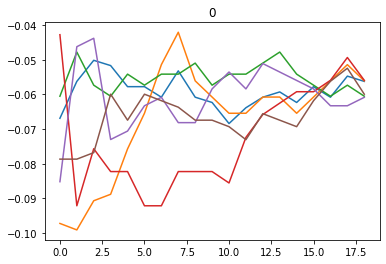

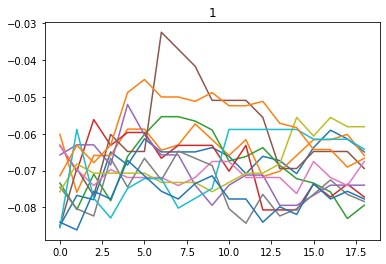

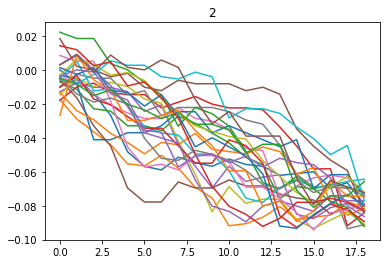

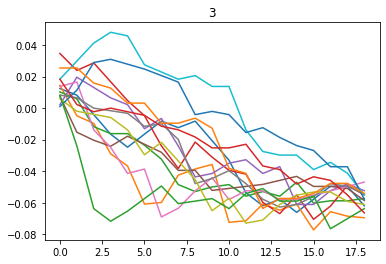

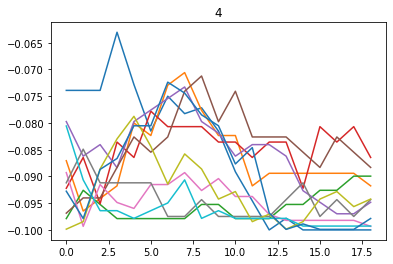

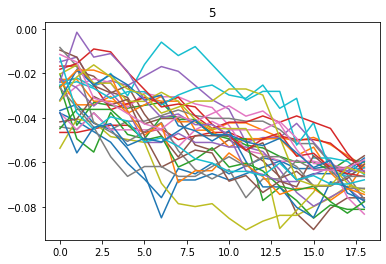

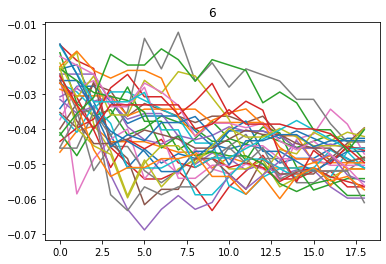

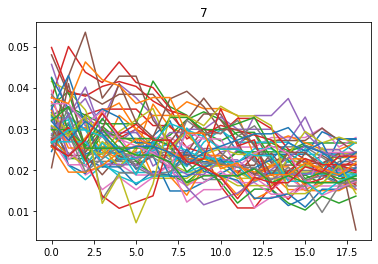

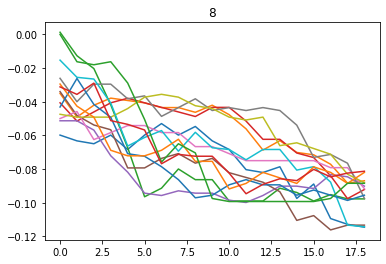

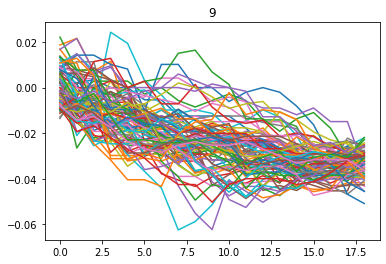

In [228]:
for n in range(10):
    plt.title(n)
    for i in range(len(X)):
    #     plt.subplot(10, 1, X_label[i]+1)
        if X_label[i] == best_short_cluster[n]:
            plt.plot(X[i])
    plt.show()

In [ ]:
print()